# Network Topology Selection: A Model Validation Perspective
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2019</div>

Choosing a good topology for the neural network is key in order to achieve a successful training as the number of layers and the numbers of unit in each layer directly determine the number of trainable weights. But how to chose the number of layers and units? This question is of particular importance in cases where neural networks are used for financial modelling as these models are subject to model governance as well as internal and external model validation. Thus, the network topology has to be chosen in a way that is compatible with model governance.

Typical approaches to chose a network topology (in financial and any other conext) are:
* **Arbitrary choice:** The model developer simply makes a choice and plays around with it until the results are satisfactory. Alternative choices are not documented or systematically evaluated.
* **Automatic Machine Learning:** There are attempts to automate the process of chosing a network topology, dubbed *AutoML*.
* **Functional Analysis:** From a mathematical perspective, a neural network is a method to approximate a non-linear function. All possible choices of network topologies constitute a space of approximation functions and thus existing theory from that area can be utilized.

The first method is of course straight-forward and quite often successfully used in practice. However, it is not always successful. For financial models, this approach is particularly problematic as it is not compatible with any model governance framework.

The second method can also work well for many practical use cases, but the problem from a model validation perspective here is that one tries to shed light into a blackbox with another blackbox. AutoML can only be used to validate a bank's machine learning solution after it has sucessfully completed a model validation process itself. That might be possible, but requires a lot of additional ressources - potentially more than to validate the neural network in question directly. Also, it is doubtful if a regulator would sign such a blank cheque.

The third method, has the advantage that a lot of literature and research already exists in that area - most famously the [universal approximation theorem for neural networks](https://en.wikipedia.org/wiki/Universal_approximation_theorem). This literature is very helpful in providing sound methodological justifications and theoretical background. However, in practice, asymptotic convergence results will often not be enough to uniquely determine the concrete parameters of the network for the problem at hand.

We will therefore propose an intermediary solution that improves the first method by some of the techniques used in the second, in particular grid search. We will formulate this proposal in a language that takes the more classical perspective of degrees of freedom that is very common in model validation. The aim is to have a framework in place that can be used in practice to get a production level machine learning application in quantitative finance through a model validation process.

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib notebook

# Multilayer Perceptron (MLP)
Let's first consider the case of MLPs. For MLPs one has to chose the number $n_L$ of layers and for each hidden layer $i$ the number $n_{u_i}$ of units. For any choice of these parameters, the degrees of freedom in the resulting MLP are precisely the number $n_w$ trainable weights, which we compute in the following.

For a primer on MLPs and the notaion convention used in the following, see [here](https://nbviewer.jupyter.org/github/niknow/machine-learning-examples/blob/master/neural_network_intro/neural_network_intro_model_setup.ipynb).

## Only 1 Layer
In the easiest case, one only has $n_L = 1$ layers. In that case, the number $n_w$ of trainable weights is given by
$$ n_w = n_o  n_i + n_o,$$
where
* $n_i$ is the number of inputs,
* $n_o$ is the number of outputs.

This is because we need a matrix in $\mathbb{R}^{n_o x n_i}$ and a vector in  $\mathbb{R}^{n_o}$ for the bias (we always assume that we train the bias).

In particular, for a network with only $n_L = 1$ layer, the topology is completely determined by the input and the output dimensions and there is no choice to be made. 

In [4]:
# in keras, this setup corresponds to
n_o = 3
n_i = 2
model = Sequential([
    Dense(units=n_o, input_shape=(n_i,)),
])
print(n_i*n_o + n_o)
model.summary()

9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


## 2 Layers
If we allow $n_L=2$ layers, then we have to choose the number $n_u$ of units in the first layer. The resulting number of weights will be
$$ n_w = n_u n_i + n_u + n_o n_u + n_o = n_u(n_i + n_o + 1) + n_o, $$
because for the first layer, we need one matrix of shape $n_u x n_i$ and a vector of shape $n_u$, and for the second layer we need a matrix of shape $n_o x n_u$ and a vector of shape $n_o$. Thus, the only parameter we need to choose is $n_u$. 

In [5]:
# in keras, this setup corresponds to
n_o = 3
n_i = 2
n_u = 10
model = Sequential([
    Dense(units=n_u, input_shape=(n_i,)),
    Dense(units=n_o),
])
print(n_u * (n_i + n_o + 1) + n_o)
model.summary()

63
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


## Arbitrary many hidden layers
In case the number of layers is $n_L \geq 3$, we have to choose the number of units $n_u$ for all but the last layers separately. If we enumerate the layers from input to output by $1, \ldots, n_L$ and denote by $n_{u_i}$ the number of units in each layer, then the total number of trainable weights is given by
$$ n_w = n_i n_{u_1} + n_{u_1} + n_{u_L} n_o + n_o + \sum_{i=2}^{n_L - 1}{n_{u_{i-1}} n_{u_{i}} +n_{u_i}},$$
which in theory leaves us with many choices. 

If we assume that all but the output layer have the same number of units, i.e. $n_{u_i}=n_u$ for $1 \leq i < N_L$, then we only have to choose one number $n_u$ and the resulting number of trainable weights simplifies to:
$$ n_w = (n_L - 2) n_u^2 + (n_i + n_o + n_L - 1)n_u + n_o ,$$
which requires $2$ choices, namely $n_L$, the number of layers, and $n_u$, the number of units per layer.

In [6]:
# in keras, an example is given by
n_o = 3
n_i = 2
n_u = 10
n_L = 5
model = Sequential([
    Dense(units=n_u, input_shape=(n_i,)),
    Dense(units=n_u),
    Dense(units=n_u),
    Dense(units=n_u),
    Dense(units=n_o),
])
print( (n_L - 2) * n_u**2 + (n_i + n_o + n_L - 1) * n_u + n_o)
model.summary()

393
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


## Balancing Layers, Units and Weights

We have seen that under the assumption that every layer has the same number of units (except the output layer), the number $n_w$ of trainable weights is a function $n_w = n_w(n_L, w_u)$ of the number $n_L$ of layers and $n_u$ of units per layer.

In order to find a good network topology for a given problem, one could of course simply try out a grid of networks parametrised by $n_L$ and $n_u$. However, if we study this function using some simple examples, we see that this might not be the best choice.

In [7]:
# implement $n_w$ function
def num_weights(n_i, n_o, n_L, n_u):
    """
    Computes the total number of parameters in an MLP assuming all layers have the same
    number of units (except the output layer).

    param n_i: number of inputs
    param n_o: number of outputs
    param n_L: number of layers
    param n_u: number of units per layer

    returns: total number of trainable weights

    """
    if n_L == 2:
        return n_u * (n_i + n_o + 1) + n_o
    else:
        return (n_L - 2) * n_u**2 + (n_i + n_o + n_L - 1) * n_u + n_o

<IPython.core.display.Javascript object>


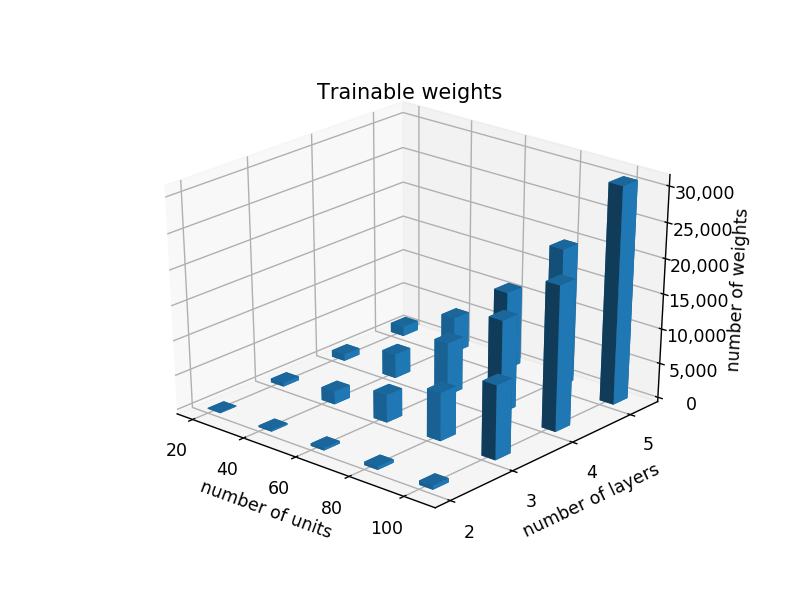

In [13]:
# create example 
n_o = 3
n_i = 2
units = np.arange(20, 120, 20)
layers = np.arange(2, 6)
xx, yy = np.meshgrid(units, layers)
x, y = xx.ravel(), yy.ravel()
z = np.array([[num_weights(n_i, n_o, l, u) for u in units] for l in layers]).ravel()
bottom = np.zeros_like(z)

# plot example
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
width = 5
depth = 0.25
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Trainable weights')
ax.set_xlabel('number of units')
ax.set_ylabel('number of layers')
ax.set_zlabel('number of weights')
ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_yticks(layers)
plt.show()

As illustrated by the above plot, the degrees of freedom in the network, i.e. the numner $n_w$ of weights, depends linearly on the number $n_L$ of layers, but quadratically on the number $n_u$ of units. This means that doubling the number of layers will double the number of weights, but doubling the number of units will quadruple the number of weights. 

Thus, if we want to find the optimal, or say a ''good'' network topology for a given problem, it is hard to say if it is better to increase the number of units or the number of layers by simply trying it out, because these increases have different effects on the number of weights. If we find that doubling the number of units (thus quadrupling the number of weights) results in a network that has a lower bias than doubling the number of layers (thus only doubling the number of weights), would it be fair to say that doubling the number of units is better?

Therefore, it is more insightful to start with a set of candidate numbers for the given units $n_u$ and then increase the number of layers, but keeping the total number of weights fixed. This can be achieved by reducing the number of units after increasing the number of layers. The mathematics of this is governed by rewriting the equation for $n_w$ 

$$ n_w = (n_L - 2) n_u^2 + (n_i + n_o + n_L - 1)n_u + n_o \quad \Longleftrightarrow  \quad  n_u^2 + \underbrace{\frac{n_i + n_o + n_L - 1}{n_L - 2}}_{=:p} n_u + \underbrace{\frac{n_o - n_w}{n_L - 2}}_{=:q} = 0
$$

and solving this quadratic equation for $n_u$. The positive solution is thus given by
$$ n_u = - \frac{p}{2} + \sqrt{\frac{p^2}{4} - q} $$

Using this we can keep the number of weights constant when increasing the number of layers. We illustrate this with an example.

In [14]:
# implement $n_u$  as function of $n_w$
def num_units(n_i, n_o, n_L, n_w):
    """
    Computes the total number ofunits per layer to achieve a given number of parameters assuming all layers 
    have the same number of units (except the output layer).

    param n_i: number of inputs
    param n_o: number of outputs
    param n_L: number of weights    
    param n_w: number of weights

    returns: number of units per layer needed

    """
    if n_L == 2:
        return int((n_w -  n_o) /(n_i + n_o + 1))
    else:
        p = n_i + n_o + n_L - 1
        p /= n_L - 2
        q = n_o - n_w
        q /= n_L - 2
        return int(-p/2 + np.sqrt(p**2/4 - q))

<IPython.core.display.Javascript object>


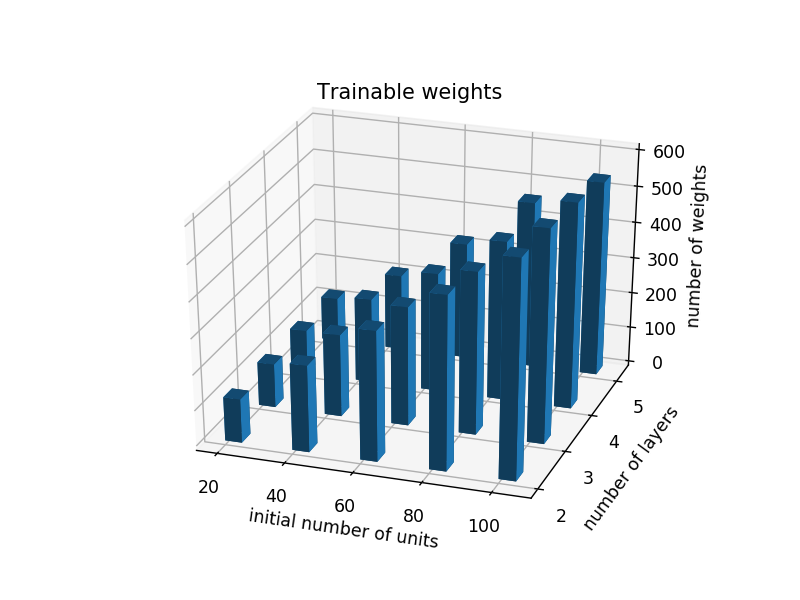

In [17]:
# create example 
n_o = 3
n_i = 2
layers = np.arange(2, 6)
units = np.arange(20, 120, 20)
weights ={u : num_weights(n_i, n_o, layers[0], u) for u in units}
xx, yy = np.meshgrid(units, layers)
x, y = xx.ravel(), yy.ravel()
z = np.array([[num_weights(n_i, n_o, l, num_units(n_i, n_o, l, weights[u])) for u in units] for l in layers]).ravel()

# plot example
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
width = 5
depth = 0.25
ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title('Trainable weights')
ax.set_xlabel('initial number of units')
ax.set_ylabel('number of layers')
ax.set_zlabel('number of weights')
ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_yticks(layers)
plt.show()

We see that the number of weights now increases linearly with the number of units, but stays roughly constant with the number of layers (because the number of units is decreased). It does not stay exactly constant due to rounding the solution of the quadratic equation.

## Network Topology Selection Algorithm

This leaves us with the following method of determining a good network topology for any given problem:

**Input:**
* An artificial neural network $\operatorname{NN}$.
* A range of number of units $\mathcal{N}_u = (n_{u_1}, \ldots, n_{u_m})$
* A range of number of layers $\mathcal{N}_L = (N_{L_1}, \ldots, N_{L_m})$
* A labeled dataset $(x,y)$ together with a train/test split (e.g. $80\%, 20\%$)
* A bias threshold $t_b$ and a variance threshold $t_v$ together with metrics for both (e.g. MSE).
* A number $e_{\max}$ of maximal epochs.


**Steps:**
* For each $n_u \in \mathcal{N}_u$ and each $n_L \in \mathcal{N}_L$ train the network $\operatorname{NN}$ with $(x,y)$ until the bias and variance is below the tresholds $t_b$ and $t_v$ (or the maximum number of epochs $e_{\max}$ is reached). This results in a grid of trained models parametrized by $\mathcal{N}_u \times \mathcal{N}_L$.
* Cross out all networks on the grid, for which the bias and the variance are not below the given thresholds. (In case all models are crossed out, the number of units or layers or the number of training samples or the number of epochs needs to be increased to yield a meaningful result.)
* Amongst the remaining, find the smallest number $n_L$ of layers, for which there exist a number of units $n_u$ such that the model $(n_u, n_L)$ has not been crossed out. Amongst those, chose the one with the smallest number $n_u$ of units. 

**Output:** A number $(n_u, n_L)$ of units and layers for the network $\operatorname{NN}$ such that the bias and the variance of the network on $(x,y)$ are within the threshold and the numbers $(n_u, n_L)$ are optimal within the given range.


## Advantages of the Algorithm

* **Documented Choice:** The resulting grid of trained models yields transparent evidence on why a network topology has been chosen.
* **Prevention of Overfitting:** Because both, the number of layers an units is increased from below, this method prevents overfitting the model.
* **Topology Type Comparison (optional):** If one does not only want to select a certain number of layers and units for a given topology type like MLP, but wants to compare MLP vs LSTM, this comparison is more meaningful as the number of trainable weights is more comparable.

## LSTM: Long-Term-Short-Term-Memory

If one wants to compare the MLP with an [Long-Term-Short-Term-Memory network (LSTM)](https://nbviewer.jupyter.org/github/niknow/machine-learning-examples/blob/master/lstm_intro/lstm_intro.ipynb), one has to determine the number of weights in an LSTM as well. 

The number of weights in a single LSTM layer with $k$ features and $m$ units is given by 
\begin{align*}
		4m^2 + 4(k+1)m.
\end{align*}

For an LSTM with $n_L-1$ layers with $n_u$ units, $n_i$ inputs followed by a single dense output layer of dimension $n_o$, we obtain
\begin{align*}
    n_w & = 4 (2 n_L -3) n_u^2  + (4 n_i + n_o + 4 n_L - 4 )n_u + n_o.
\end{align*}